<a href="https://colab.research.google.com/github/virgo21510023/data-expert/blob/main/Youtube_Recommendation_Data_Expert_02_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emoji --upgrade
!pip install langdetect --upgrade

In [2]:
#import library yg dibutuhkan

from textwrap import wrap

import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [3]:
trending = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Indonesia's Trending YouTube Video Statistics/archive (1).zip (Unzipped Files)/trending.csv", parse_dates=["publish_time"])
# Removed 'trending_time' from parse_dates, as it will be handled separately

# Convert 'trending_time' to datetime with the correct format
# The error was caused by some date entries missing microseconds, which the original format string required.
# This updated format string is more flexible and handles both cases with and without microseconds.
trending['trending_time'] = pd.to_datetime(trending['trending_time'], format='%Y-%m-%d %H:%M:%S.%f%z', utc=True, errors='coerce')
# Added errors='coerce' to handle invalid parsing and set them to NaT (Not a Time)
# You can then decide how to handle these NaT values.

print(trending)

           video_id              publish_time                channel_id  \
0               NaN 2021-02-05 09:00:34+00:00  UCEf_Bc-KVd7onSeifS3py9g   
1               NaN 2021-02-04 15:54:08+00:00  UCYEa4_MC7OFjcWrO6SO-u8g   
2               NaN 2021-02-06 03:00:22+00:00  UCu12RxQjRQyh79YBYvEDkOg   
3               NaN 2021-02-05 20:26:08+00:00  UCCuzDCoI3EUOo_nhCj4noSw   
4               NaN 2021-02-03 23:14:54+00:00  UC14UlmYlSNiQCBe9Eookf_A   
...             ...                       ...                       ...   
172342  7bWA417DiWI 2023-08-09 13:30:10+00:00  UCZWk_k207M--sLScrLdM3JQ   
172343  60_X2aML0x8 2023-08-12 00:00:05+00:00  UCcqmUSGYsTrPv9DoiaqzRwA   
172344  Khl5VR92d0U 2023-08-10 03:09:28+00:00  UCfZNq8mYot3GwCmJitQxL4g   
172345  Xyca4BHOhpQ 2023-08-08 12:00:22+00:00  UCUE-BF1Q5E6Sz1KidSnSRYw   
172346  kJi-3UL3Fbc 2023-08-09 10:42:55+00:00  UCHoX7CztP2HlWACVVEtkv-w   

                                                    title  \
0                             aespa 에스

In [4]:
def get_category_dict(category_file):
  category = pd.read_json(category_file, orient="records")
  category = pd.DataFrame(category["items"].values.tolist())

  return {
      cat.id: cat.snippet.get("title")
      for cat in category.itertuples(index=False)
  }

In [5]:
category_dict = get_category_dict("/content/drive/MyDrive/Colab Notebooks/Indonesia's Trending YouTube Video Statistics/archive (1).zip (Unzipped Files)/category.json")

In [6]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()
print(f"Start date: {start_date}")
print(f"End date: {end_date}")

Start date: 2021-02-07 05:46:51.832614+00:00
End date: 2023-09-01 09:16:49.916211+00:00


In [7]:
#delete data dari bulan februari sampai september

filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()
print(f"Start date: {start_date}")
print(f"End date: {end_date}")

Start date: 2021-07-01 06:01:25.524449+00:00
End date: 2023-09-01 09:16:49.916211+00:00


In [8]:
num_videos = filtered_trending.shape[0]
print(f"Number of videos: {num_videos}")

Number of videos: 81517


Terdapat **81.517** video yang masuk daftar trending setiap harinya dari bulan Juli sampai Desember.

In [9]:
#distribusi missing value

filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81517 entries, 21322 to 172346
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           49717 non-null  object             
 1   publish_time       81517 non-null  datetime64[ns, UTC]
 2   channel_id         81517 non-null  object             
 3   title              81517 non-null  object             
 4   description        78544 non-null  object             
 5   thumbnail_url      49717 non-null  object             
 6   thumbnail_width    49717 non-null  float64            
 7   thumbnail_height   49717 non-null  float64            
 8   channel_name       81517 non-null  object             
 9   tags               70149 non-null  object             
 10  category_id        81517 non-null  int64              
 11  live_status        81517 non-null  object             
 12  local_title        81517 non-null  object     

In [10]:
#delete video dg description kososng

filtered_trending.dropna(subset=['description'], inplace=True)

# Exploratory Data Analysis

In [11]:
#kelompokkan data berdasarkan tanggal per hari
#hitung jumlah video pada tanggal tersebut

trending_by_date = filtered_trending.groupby(
    filtered_trending.trending_time.dt.date
)

num_trending_per_day = trending_by_date.trending_time.count()
print(num_trending_per_day)

trending_time
2021-07-01    195
2021-07-02    196
2021-07-03    195
2021-07-04    195
2021-07-05    195
             ... 
2023-08-28    188
2023-08-29    187
2023-08-30    186
2023-08-31    187
2023-09-01    186
Name: trending_time, Length: 412, dtype: int64


Jadi, setiap harinya, + 190 video yang masuk dalam daftar trending YouTube dari tanggal 1 Juli sampai 31 Desember.

# Trending Duration

In [12]:
#cek berapa lama durasi suatu video bisa bertahan dalam trending YT

trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(
        column="trending_time", aggfunc="count"),
    first_trending_date=pd.NamedAgg(
        column="trending_time", aggfunc="min"),
    last_trending_date=pd.NamedAgg(
        column="trending_time", aggfunc="max")
).sort_values(by="trending_duration", ascending=False)

trending_duration.head(10)

,trending_duration,first_trending_date,last_trending_date
title,,,
Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00
"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT DARI RUMAH???",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00
"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE NENTENGIN PEDANG !",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00
OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00
"Tantangin VYN Pake Franco, 1 Kali Kena Hook Dapet Rp 500 Ribu! - Mobile Legends",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00
SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00
Kok di Indonesia ada penjual Rawon yg lebih pintar ngrap dari rapper Korea ya..?,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00
SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00
"HANYA FARIDA NURHAN, MUKBANG MIE GACOAN LEVEL IBLIS DAN SETAN BERSAMAAN!!",32,2022-07-11 06:00:59.414152+00:00,2022-08-11 06:01:46.801212+00:00


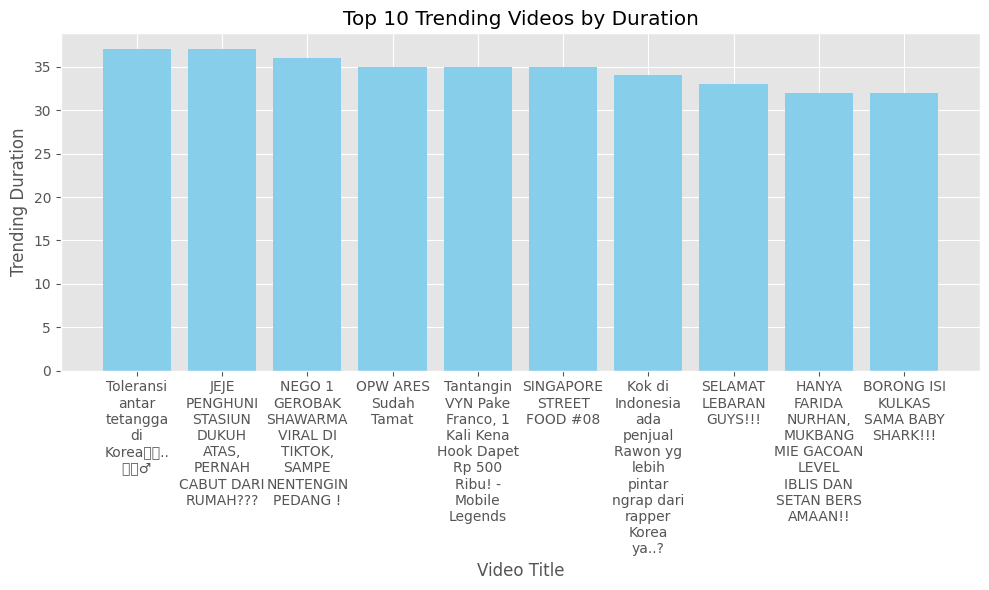

In [13]:
#visualisasi data trending dengan bar chart

plt.figure(figsize=(10, 6))
plt.bar(
    trending_duration.index[:10].to_series().apply(lambda title: '\n'.join(wrap(title, width=10))), # Access the index and convert to Series to use apply
    trending_duration.trending_duration[:10],
    color='skyblue'
)

plt.xlabel('Video Title')
plt.ylabel('Trending Duration')
plt.title('Top 10 Trending Videos by Duration')
plt.tight_layout()
plt.show()

# Most Viewed, Liked, and Disliked Video

In [14]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min", "max", "mean", "sum"])

trending_rewind.head(10)

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1798947.0  2064042.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...   393043.0  1348612.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...   503651.0   822845.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...  1398186.0  1398186.0   
"KEJUTAN YANG DITUNGGU" DUET DRIVER HITS EKS HR...   200704.0   303038.0   
"KEMBALIKAN UANG RAKYAT " LIHAT LANGSUNG HEREX ...    91797.0    91797.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1.981122e+06  19811225.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  1.126182e+06  14640369.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...  7.171452e+05   3585726.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...  1.398186e+06   1398186.0   
"KEJUTAN YANG DITUNGGU" DUET DRIVER HITS EKS HR...  2.666275e+05   3466157.0   
"KEMBALIKAN UANG RAKYAT " LIHAT LANGSUNG HEREX ...  9.179700e+04     91797.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         41528.0   44699.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  127824.0  262846.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...    6952.0    9144.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...   44228.0   44228.0   
"KEJUTAN YANG DITUNGGU" DUET DRIVER HITS EKS HR...    4172.0    4840.0   
"KEMBALIKAN UANG RAKYAT " LIHAT LANGSUNG HEREX ...    1646.0    1646.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         43795.800000   437958.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  237112.769231  3082466.0   
"Ini adalah IMPIAN bapa saya" - Tangisan Goh Li...    8436.200000    42181.0   
"JANGAN DIKASARIN YA PAK.." CREW SETIA FARM SED...   44228.000000    44228.0   
"KEJUTAN YANG DITUNGGU" DUET DRIVER HITS EKS HR...    4613.230769    59972.0   
"KEMBALIKAN UANG RAKYAT " LIHAT LANGSUNG HEREX ...    1646.000000     1646.0   

                       

### Visualisasi

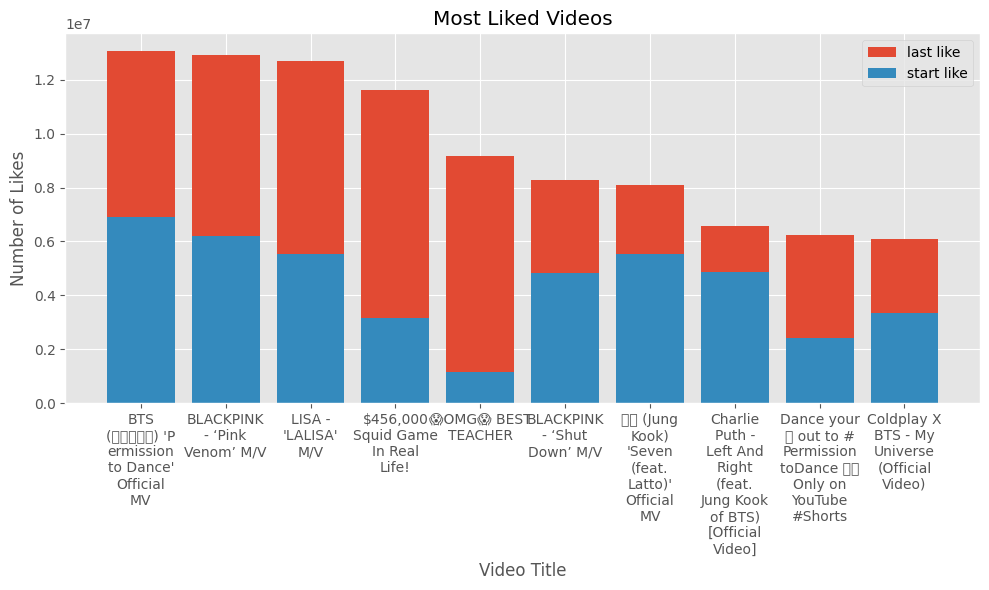

In [15]:
#visualisasi trending video teratas masing2

top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_liked.index.to_series().apply(lambda title: '\n'.join(wrap(title, width=10))), top_10_liked["max"], label="last like")
plt.bar(top_10_liked.index.to_series().apply(lambda title: '\n'.join(wrap(title, width=10))), top_10_liked["min"], label="start like")
plt.title("Most Liked Videos")
plt.xlabel("Video Title")
plt.ylabel("Number of Likes")
plt.legend()
plt.tight_layout()
plt.show()

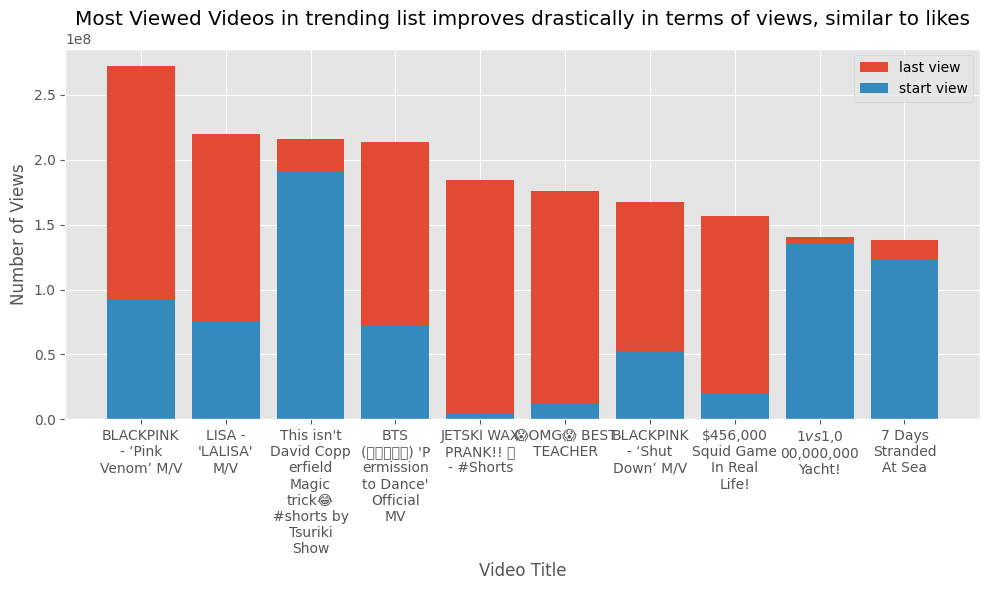

In [16]:
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_viewed.index.to_series().apply(lambda title: '\n'.join(wrap(title, width=10))), top_10_viewed["max"], label="last view")
plt.bar(top_10_viewed.index.to_series().apply(lambda title: '\n'.join(wrap(title, width=10))), top_10_viewed["min"], label="start view")
plt.title("Most Viewed Videos in trending list improves drastically in terms of views, similar to likes")
plt.xlabel("Video Title")
plt.ylabel("Number of Views")
plt.legend()
plt.tight_layout()
plt.show()

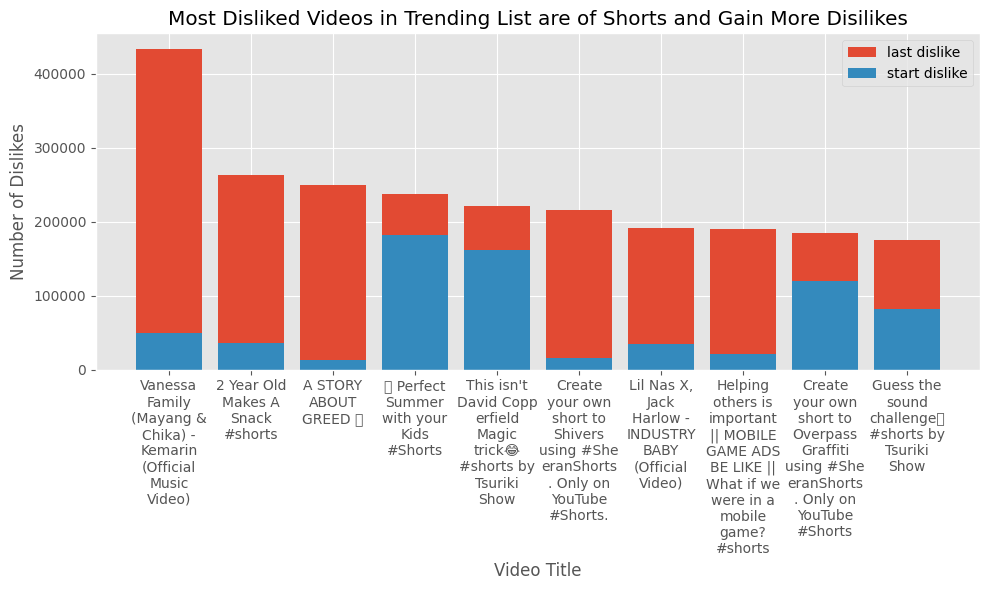

In [17]:
top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_disliked.index.to_series().apply(lambda title: '\n'.join(wrap(title, width=10))), top_10_disliked["max"], label="last dislike")
plt.bar(top_10_disliked.index.to_series().apply(lambda title: '\n'.join(wrap(title, width=10))), top_10_disliked["min"], label="start dislike")
plt.title("Most Disliked Videos in Trending List are of Shorts and Gain More Disilikes")
plt.xlabel("Video Title")
plt.ylabel("Number of Dislikes")
plt.legend()
plt.tight_layout()
plt.show()

# NLP (Natural Language Processing)

###Data Preparation

In [18]:
sample = filtered_trending.sample(10, random_state=15)
sample [["title", "description"]]

,title,description
91416,UNTUK PERTAMA KALINYA RAZOR CEMBURU KEPADA IKK...,"Hallo guys!\n\nDi konten kali ini gue, Razor F..."
104839,Alter Ego vs ONIC Game 3 MPL ID S10 | ONIC vs ...,Alter Ego vs ONIC Game 3 MPL ID S10 | ONIC vs ...
38389,PMPL S4 INDONESIA GRAND FINAL DAY 2 | MISI PEM...,🔱 16 Tim\n*️⃣ 1 Tujuan\n🏆 JUARA!\n\nGrand Fina...
116633,KITA MENDAPATKAN BARANG PALING ANEH DI WOBBLY ...,Stresmen main woBbly life\n- Subscribe guys\n-...
22901,Dance by SHOTARO of NCT | ‘Wake Up’,#SHOTARO #DANCE\n#DancebySHOTAROofNCT\n#쇼타로 #N...
22056,茭白——甜脆爽口，凉拌、炒肉都好吃【滇西小哥】,家里猪圈牛圈改造基本收尾了，大部分工作都是请村里的师傅做完了，剩下一些零碎的工作就是我自己收...
117163,AleXa (알렉사) – 'Back In Vogue' Official MV,Stream Back In Vogue:\n⇢ https://wmk.lnk.to/Gi...
107358,[ID] 2022 PUBG MOBILE Regional Clash D1,"PUBG Mobile Regional Clash, turnamen perdana y..."
167463,Sadar Posisi,Provided to YouTube by RC Music\n\nSadar Posis...
49161,SQUID GAME FANFICS BE LIKE 🔺,"Hey Alan Army, this is Alan Chikin Chow! This ..."


In [19]:
#mengubah title dan deskripsi video menjadi lowercase

sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))


In [20]:
with pd.option_context("display.max_colwidth", 100):
  display(sample[["title", "title_lang", "description", "desc_lang"]])

,title,title_lang,description,desc_lang
91416,UNTUK PERTAMA KALINYA RAZOR CEMBURU KEPADA IKKE !!! PADAHAL NIATNYA CUMA MAIN GAMES !!!,id,"Hallo guys!\n\nDi konten kali ini gue, Razor Fathanah bakal Qna lagi bareng Ikke Mau liat konten...",id
104839,Alter Ego vs ONIC Game 3 MPL ID S10 | ONIC vs AE ESPORTSTV,ca,Alter Ego vs ONIC Game 3 MPL ID S10 | ONIC vs AE ESPORTSTV\n\n#ESPORTSTV #AE #ONIC http://bit.ly...,en
38389,PMPL S4 INDONESIA GRAND FINAL DAY 2 | MISI PEMBUKTIAN TIM KUDA HITAM,id,🔱 16 Tim\n*️⃣ 1 Tujuan\n🏆 JUARA!\n\nGrand Finals PMPL ID S4 Dimulai! 16 Tim teratas dari babak R...,id
116633,KITA MENDAPATKAN BARANG PALING ANEH DI WOBBLY LIFE!!!,id,Stresmen main woBbly life\n- Subscribe guys\n- Jangan lupa Like\n- Tonton sampe habis!!!\n\nemai...,en
22901,Dance by SHOTARO of NCT | ‘Wake Up’,en,#SHOTARO #DANCE\n#DancebySHOTAROofNCT\n#쇼타로 #NCT \n\nNCT Official\nhttp://www.youtube.com/nctsmt...,en
22056,茭白——甜脆爽口，凉拌、炒肉都好吃【滇西小哥】,zh-cn,家里猪圈牛圈改造基本收尾了，大部分工作都是请村里的师傅做完了，剩下一些零碎的工作就是我自己收尾。这几天的茭白正是季节，甜甜嫩嫩的，特别特别脆甜，在云南忙的时候就直接烫一碗菌香干拌米线，1分钟搞...,en
117163,AleXa (알렉사) – 'Back In Vogue' Official MV,en,Stream Back In Vogue:\n⇢ https://wmk.lnk.to/GirlsGoneVogue2\n\nOrder Girls Gone Vogue:\n⇢ https:...,en
107358,[ID] 2022 PUBG MOBILE Regional Clash D1,it,"PUBG Mobile Regional Clash, turnamen perdana yang diadakan PUBG Mobile dengan mempertemukan tim ...",id
167463,Sadar Posisi,id,Provided to YouTube by RC Music\n\nSadar Posisi · Happy Asmara · Kurniawan Bayu Subekti · Kurnia...,en
49161,SQUID GAME FANFICS BE LIKE 🔺,en,"Hey Alan Army, this is Alan Chikin Chow! This video is called Squid Game Fanfics Be Like. Have y...",en


In [21]:
#membuat fungsi untuk mendeteksi bahasi dari sebuah teks

def detect_language(text):
  """Detect language of the 'text' ."""
  try:
    lang = langdetect.detect(text)
    return lang
  except:
    return

In [22]:
filtered_trending["title_lang"] = filtered_trending.title.apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending.description.apply(detect_language)

In [24]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,en,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
172342,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,en,#sule #njan #inibukantalkshow #rizkyfebian #pu...,id
172343,Sangkolan 1 | short movie madura ( SUB INDONES...,id,Welcome to @Akeloy Production \nKali ini kami...,id
172344,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,de,#desa #pulangkampung #yennydichina #indonesi...,id
172345,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,id,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",id


In [26]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") & (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_colwidth", None):
  display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,...,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
26415,NaN,2021-07-20 23:00:17+00:00,UC_nVG23zK0hZUxJXEhArTkw,"Siapa yang melukis paling bagus, mendapatkan hadiahnya #3 Multi DO","Menggambar hadiah tidak hanya menarik, tapi juga sangat menyenangkan. Ketika ada satu hadiah, dan ada beberapa peserta, ini menciptakan perjuangan tak terlupakan, yang sangat menarik untuk dilihat. Terutama jika Anda berada di sebuah Multi DO!\n\nJangan lupa untuk berbagi pakaian ini Lifehacks Dengan saudara dan teman-teman Anda dan pastikan Anda menekan tombol Langganan yang dan... lihat Ya!\n\n#MultiDO #pranks #lucu",NaN,NaN,NaN,Multi DO Indonesian,"['swakriya', 'kerajinan', 'kerajinan-kerajinan', 'kejailan', 'kejailan-kejailan', 'tantangan', 'tantangan-tantangan', 'seru', 'lucu', 'multi do', 'multido', 'jail', 'teman', 'ramah', 'tutorial', 'kiat', 'cara']",...,NaN,NaN,365316.0,1968.0,431.0,0,75.0,2021-07-26 06:00:50.581830+00:00,id,id
47291,NaN,2021-11-01 08:00:13+00:00,UCw-y_a0yOWQ6ChCZp0RcMAQ,Ndarboy feat. Awang Ngatmombilung - Pingal (Festival Suara Kerakyatan),"Ndarboy Feat Awang Ngatmombilung - Pingal (Festival Suara Kerakyatan)\n\nPINGAL \nCiptaan : Andry priyanta\n\nInfo Mabes Balker :\nhttps://linktr.ee/MabesBalker\n\nOriginal Video clip Pingal :\nhttps://youtu.be/Wf53XZEUMLg\n\nTerimakasih atas subscribe, like, dan komentar dari kalian semua lur. \nGAS POLL NDANGAK !\n\nThanks to :\nAsmaralaya Art Production\nhttps://www.instagram.com/asmaralaya_art_pro/\nVolcano Production\nhttps://www.instagram.com/volcano_pro/\n\nSeduluran selawase, panjang umur dangdut cidro asmoro\n\nLirik: PINGAL\n\nPiye.\nSeng jelaske karo wongtuwo\nWes ngelakoni tekan semene\nNek akhire bakal bubar pisahan\nKowe kegudo tresno karo wong liyo\n\nNgelali.\nKowe sing tau omong dewe\nNglakoni tresno tekan tuwo\nOra ngeliyo mung aku ning atimu\nNanging saiki atimu ono wong liyo\n\nIbarat esuk mendung, awan aku kudanan\nSore mbok larani, bengi tak tangisi\n\nMung iso bayangke kabeh kenangan\nKowe tak boncengke\nTurut dalan kekepan kudanan\nSaiki nyatane kowe malah milih\nDikekep wong liyo\n\nOpo kowe ra kroso abote atiku\nKudu kelangan wong sing paling tak tresnani\nRa jenak dolan, ra doyan mangan\nNek ra mbok dulang\n\nIbarat esuk mendung, awan aku kudanan\nSore mbok larani, bengi tak tangisi\n\nMung iso bayangke kabeh kenangan\nKowe tak boncengke\nTurut dalan kekepan kudanan\nSaiki nyatane kowe malah milih\nDikekep wong liyo\n\nOpo kowe ra kroso abote atiku\nKudu kelangan wong sing paling tak tresnani\nRa jenak dolan, ra doyan mangan\nNek ra mbok dulang\n\nRa jenak dolan, ra doyan mangan\nNek ra mbok dulang\n\n#Ndarboy #Pingal #Ngatmombilung\n========================================\nLicensed to YouTube by IDE (Music)\nThis channel & Video optimized by IDE Optimization\nLicense your music here: https://smarturl.id/idemusic\nOptimize your video now: https://smarturl.id/optimize",NaN,NaN,NaN,Mabes Balker Official,"['ndarboy Feat Awang', 'Ndarboy Pingal', 'Ndarboy Feat Ngatmombilung', 'ndarboy genk pingal', 'pingal ndarboy', 'pingal ngatmombilung', 'festival suara kerakyatan', 'awang ngatmombilung', 'ndarboygenk suara kerakyatan', 'Pingal terbaru', 'Pingal ngatmombilung', 'PINGAL', 'Ngatmombilung', 'full album', 'mix ngatmombilung', 'mix ndarboy genk']",...,NaN,NaN,270284.0,7616.0,177.0,0,1319.0,2021-11-07 06:01:54.001169+00:00,id,id
47368,NaN,2021-11-05 16:21:31+00:00,UCYqOeAXJm8yV9sJ8Ud3cR7A,"KONTROVERSI! Penalti Marco Motta (Persija) yang Berawal dan Berakhir Dramatis, Ada Apa? | BRI Liga 1","Tonton tayangan lengkap Indosiar di vidio.com atau klik https://www.vidio.com/watch/2345165-mini-match-persija-jakarta-vs-barito-putera-bri-liga-1?utm_source=youtube&utm_medium=referrer-description&utm_campaign=indosiar\n\nPersija sebenarnya mendapat peluang untuk menang lewat titik penalti, namun sayang Marco M

## Feature Extraction

In [30]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

,title,description,category_id
0,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
1,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
2,Momen Kocak! KASAD Jenderal Andika Cari Prajur...,VIVA - Baru-baru ini beredar sebuah video lama...,25
3,"Baru Datang, Azis Gagap Sudah Bikin Ngakak | L...","LAPOR PAK!\nSelasa, 22 Juni 2021\n\nPART 1 : h...",24
4,Rey Mbayang - Sempurnakan Hariku (Official Mus...,Title: Sempurnakan Hariku \nArtist: Rey Mbayan...,10
...,...,...,...
19302,Mushoku Tensei: Jobless Reincarnation Season 2...,✅ Subscribe Muse Indonesia: https://www.youtub...,1
19303,David Iztambul feat Fauzana - Rindu Sampai Ka ...,Official Music Video by David Iztambul feat Fa...,24
19304,Nemu Ayu Cantika Live In TPI Mojo Pemalang M...,Orkes Pengiring : MAHESA Music | Cp For Job : ...,10
19305,Sangkolan 1 | short movie madura ( SUB INDONES...,Welcome to @Akeloy Production \nKali ini kami...,24


## Duplicates

In [31]:
data.drop_duplicates(subset="title", inplace=True)
data

,title,description,category_id
0,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
1,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
2,Momen Kocak! KASAD Jenderal Andika Cari Prajur...,VIVA - Baru-baru ini beredar sebuah video lama...,25
3,"Baru Datang, Azis Gagap Sudah Bikin Ngakak | L...","LAPOR PAK!\nSelasa, 22 Juni 2021\n\nPART 1 : h...",24
4,Rey Mbayang - Sempurnakan Hariku (Official Mus...,Title: Sempurnakan Hariku \nArtist: Rey Mbayan...,10
...,...,...,...
19268,Gw Ketemu Minecraft World Paling Pertama Gw .....,Halo semua ! Selamat datang di channel ini !\n...,20
19271,Niken Salindry ft. Masdddho - Cinta Tak Terpis...,Judul : Cinta Tak Terpisahkan\nSong...,10
19272,GUNUNG DJADI - Atap Negeri Riau #2,Temukan Fiersa Besari di\nInstagram https://ww...,19
19273,"Japri Nikah Siri, Paing Jadi Sirik","Japri kali ini membuat Paing menjadi marah, ap...",23


In [32]:
data.reset_index(drop=True, inplace=True)
data.shape

(3413, 3)

## Feature Engineering

In [35]:
list_emoji = [e for e in emoji.EMOJI_DATA.keys()]

count = 0
for em in list_emoji:
  for title in data.title:
    if em in title:
      count += 1
      print("How many titles use emoji?", count)

How many titles use emoji? 1
How many titles use emoji? 2
How many titles use emoji? 3
How many titles use emoji? 4
How many titles use emoji? 5
How many titles use emoji? 6
How many titles use emoji? 7
How many titles use emoji? 8
How many titles use emoji? 9
How many titles use emoji? 10
How many titles use emoji? 11
How many titles use emoji? 12
How many titles use emoji? 13
How many titles use emoji? 14
How many titles use emoji? 15
How many titles use emoji? 16
How many titles use emoji? 17
How many titles use emoji? 18
How many titles use emoji? 19
How many titles use emoji? 20
How many titles use emoji? 21
How many titles use emoji? 22
How many titles use emoji? 23
How many titles use emoji? 24
How many titles use emoji? 25
How many titles use emoji? 26
How many titles use emoji? 27
How many titles use emoji? 28
How many titles use emoji? 29
How many titles use emoji? 30
How many titles use emoji? 31
How many titles use emoji? 32
How many titles use emoji? 33
How many titles use

In [36]:
def demojize(text):
  for em in list_emoji:
    if em in text:
      em_text = emoji.demojize(em)
      text = text.replace(em, " " + em_text + " ")
  return text

In [37]:
data["title_emoji"] = data.title.apply(demojize)

In [38]:
title_width_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]

In [39]:
with pd.option_context("display.max_colwidth", 100):
  display(data.loc[title_width_emoji_idx, ["title", "title_emoji"]])

,title,title_emoji
17,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih...❤,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih.....
43,BIKIN CEWEK TERPESONA 😍 Aksi Heroik Driver Muda Menolong Sopir Yang Kesulitan di Sitinjau Lauik,BIKIN CEWEK TERPESONA :smiling_face_with_heart-eyes: Aksi Heroik Driver Muda Menolong Sopir Ya...
44,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN ✅ ✅ ✅,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN :check_mark_button: :check_mark_butto...
174,TERSINGGUNG‼️🤣 - Pemuda Tersesat - Deddy Corbuzier Podcast,TERSINGGUNG :double_exclamation_mark: :rolling_on_the_floor_laughing: - Pemuda Tersesat - Dedd...
174,TERSINGGUNG‼️🤣 - Pemuda Tersesat - Deddy Corbuzier Podcast,TERSINGGUNG :double_exclamation_mark: :rolling_on_the_floor_laughing: - Pemuda Tersesat - Dedd...
...,...,...
3388,KAYRIVLOG: From Harajuku to Bridal Shower 🥺👰🏻‍♀️💍,KAYRIVLOG: From Harajuku to Bridal Shower :pleading_face: :person_with_veil: :light_skin_tone...
3388,KAYRIVLOG: From Harajuku to Bridal Shower 🥺👰🏻‍♀️💍,KAYRIVLOG: From Harajuku to Bridal Shower :pleading_face: :person_with_veil: :light_skin_tone...
3388,KAYRIVLOG: From Harajuku to Bridal Shower 🥺👰🏻‍♀️💍,KAYRIVLOG: From Harajuku to Bridal Shower :pleading_face: :person_with_veil: :light_skin_tone...
3388,KAYRIVLOG: From Harajuku to Bridal Shower 🥺👰🏻‍♀️💍,KAYRIVLOG: From Harajuku to Bridal Shower :pleading_face: :person_with_veil: :light_skin_tone...


In [40]:
#delete kolom title

data.drop(columns="title", inplace=True)

# Eksplorasi

In [41]:
desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojize)

with pd.option_context("display.max_colwidth", 100):
  display(data.loc[desc_with_emoji_idx, ["description", "desc_emoji"]])

,description,desc_emoji
4,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...","Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger..."
5,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
5,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
12,⚫︎Maria Ozawa-san\n・YouTube : MARIA OZAWA【Official】\nhttps://www.youtube.com/channel/UCgObE6CsJ0...,:black_circle: ︎Maria Ozawa-san\n・YouTube : MARIA OZAWA【Official】\nhttps://www.youtube.com/chan...
12,⚫︎Maria Ozawa-san\n・YouTube : MARIA OZAWA【Official】\nhttps://www.youtube.com/channel/UCgObE6CsJ0...,:black_circle: ︎Maria Ozawa-san\n・YouTube : MARIA OZAWA【Official】\nhttps://www.youtube.com/chan...
...,...,...
3412,✅ Subscribe Muse Indonesia: https://www.youtube.com/c/MuseID?sub_confirmation=1\n✅ Subscribe Mus...,:check_mark_button: Subscribe Muse Indonesia: https://www.youtube.com/c/MuseID?sub_confirmatio...
3412,✅ Subscribe Muse Indonesia: https://www.youtube.com/c/MuseID?sub_confirmation=1\n✅ Subscribe Mus...,:check_mark_button: Subscribe Muse Indonesia: https://www.youtube.com/c/MuseID?sub_confirmatio...
3412,✅ Subscribe Muse Indonesia: https://www.youtube.com/c/MuseID?sub_confirmation=1\n✅ Subscribe Mus...,:check_mark_button: Subscribe Muse Indonesia: https://www.youtube.com/c/MuseID?sub_confirmatio...
3412,✅ Subscribe Muse Indonesia: https://www.youtube.com/c/MuseID?sub_confirmation=1\n✅ Subscribe Mus...,:check_mark_button: Subscribe Muse Indonesia: https://www.youtube.com/c/MuseID?sub_confirmatio...


In [42]:
#hapus kolom description
data.drop(columns="description", inplace=True)

In [43]:
#gabungkan title_moji dan desc_moji menjadi satu teks panajang ke kolom all_text
data["all_text"] = data.title_emoji + " " + data.desc_emoji

#Text Processing

In [44]:
#data split
X_train, X_dev, y_train, y_dev = train_test_split(
    data.all_text, data.category_id, test_size=0.2, stratify=data.category_id, random_state=11
)
training_size = X_train.shape[0]
dev_size = X_dev.shape[0]
print(f"Training size: {training_size}")
print(f"Dev size: {dev_size}")

#define vectorizer
vectorizer = TfidfVectorizer(min_df=0.015, max_df=0.7, ngram_range=(1, 1))

#generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print(f"Train shape: {train_tfidf.shape}")
print(f"Dev shape: {dev_tfidf.shape}")

#convert to dataframe
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf_df = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

Training size: 2730
Dev size: 683
Train shape: (2730, 1042)
Dev shape: (683, 1042)


In [45]:
with pd.option_context("display.max_columns", 100):
  display(train_tfidf_df.sample(5))

,00,01,02,03,04,06,07,08,09,10,11,12,123,123go,13,14,15,16,17,18,19,1dvz1au,1gxqz9s,1st,20,2020,2021,2022,2023,21,22,23,24,25,26,28,29,2oukyag,2yfofxp,30,31,34,38,3ws0f48,40,41,45,48,50,53,...,us,usai,user,utama,utm_campaign,utm_medium,utm_source,v7,vallen,vanessa,via,video,videonya,videos,vidio,viral,vocal,vs,vt,wa,waktu,wanita,warga,warna,watch,watching,web,website,welcome,wes,whatsapp,wib,wilayah,with,withyoutube,wong,world,www,ya,yaa,yah,yaitu,yang,yeni,yg,you,your,youtu,youtube,yuk
52,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.071408,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.192402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.039534,0.0,0.0,0.0,0.132952,0.037718,0.0,0.0,0.107272,0.0,0.000000,0.047740,0.0
958,0.246254,0.069648,0.0,0.07448,0.0,0.0,0.137354,0.0,0.132686,0.059758,0.000000,0.060876,0.0,0.0,0.000000,0.065941,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.041892,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.047865,0.0,0.0,0.0,0.0,0.0,0.0,0.063835,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041031,0.0,0.0,0.000000,0.130514,0.0,0.0,0.0,0.0,0.0,0.115964,0.0,0.0,0.0,0.000000,0.066383,0.0,0.0,0.000000,0.0,0.000000,0.112029,0.0
28,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.046318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.035810,0.0,0.0,0.0,0.000000,0.136662,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1376,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.069845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.378003,0.0,0.0,0.0,0.000000,0.051520,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2059,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.027543,0.026682,0.028058,0.0,0.0,0.030093,0.030392,0.02975,0.029475,0.031231,0.030152,0.15857,0.0,0.0,0.0,0.027139,0.0,0.019308,0.0,0.0,0.024745,0.053072,0.032415,0.027882,0.037533,0.034023,0.034225,0.038031,0.0,0.0,0.022061,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059612,0.027653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.034539,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.660651,0.000000,0.0


# Modelling

##Model Training & Evaluation

In [46]:
dict_model = {
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(random_state=11),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
}

In [48]:
for model in dict_model.values():
  print(f"Model: {model.__class__.__name__}")
  model.fit(train_tfidf, y_train)
  y_pred = model.predict(dev_tfidf)
  print(classification_report(y_dev, y_pred))
  print("-" * 50)

Model: LogisticRegression
              precision    recall  f1-score   support

           1       0.94      0.82      0.88        39
           2       1.00      0.21      0.35        14
          10       0.95      0.92      0.94       103
          15       0.00      0.00      0.00         1
          17       1.00      0.37      0.54        19
          19       1.00      0.71      0.83         7
          20       0.94      0.77      0.85        39
          22       0.71      0.64      0.67        61
          23       0.83      0.31      0.45        16
          24       0.73      0.95      0.83       228
          25       0.89      0.92      0.90       118
          26       0.80      0.40      0.53        10
          27       1.00      0.25      0.40         8
          28       1.00      0.85      0.92        13
          29       1.00      1.00      1.00         7

    accuracy                           0.83       683
   macro avg       0.85      0.61      0.67       683


##Hyperparameter Tuning

###Linear SVC

In [52]:
svm_grid_search = GridSearchCV(
    dict_model["svm"],
    param_grid={
        "C": [10, 1, 0.1, 0.05, 0.01]},
)

svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print(classification_report(y_train, svm_grid_search.predict(train_tfidf)))
print(classification_report(y_dev, svm_pred_dev))
svm_pred_dev = svm_grid_search.predict(dev_tfidf)
print(classification_report(y_train, svm_grid_search.predict(train_tfidf)))
print(classification_report(y_dev, svm_pred_dev))

              precision    recall  f1-score   support

           1       0.97      0.97      0.97       155
           2       1.00      1.00      1.00        56
          10       0.98      1.00      0.99       410
          15       1.00      0.67      0.80         6
          17       0.96      0.93      0.94        73
          19       1.00      0.96      0.98        27
          20       0.99      0.98      0.98       156
          22       1.00      0.92      0.96       244
          23       0.98      0.94      0.96        65
          24       0.97      0.98      0.98       909
          25       0.97      1.00      0.98       473
          26       0.95      0.95      0.95        42
          27       1.00      1.00      1.00        32
          28       1.00      1.00      1.00        52
          29       1.00      0.97      0.98        30

    accuracy                           0.98      2730
   macro avg       0.98      0.95      0.97      2730
weighted avg       0.98   

In [53]:
svm_grid_search.best_params_

{'C': 1}

###Random Forest Classifier

In [56]:
random_forest_grid_search = GridSearchCV(
    dict_model["random_forest"],
    param_grid={
        "n_estimators": [10, 20, 25, 50, 75, 100, 125],
        "max_depth": [5, 10, 25, 50]
    }
)

random_forest_grid_search.fit(train_tfidf, y_train)
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)
print(classification_report(y_train, random_forest_grid_search.predict(train_tfidf)))
print(classification_report(y_dev, random_forest_pred))
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)
print(classification_report(y_train, random_forest_grid_search.predict(train_tfidf)))
print(classification_report(y_dev, random_forest_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       155
           2       1.00      0.98      0.99        56
          10       1.00      1.00      1.00       410
          15       1.00      0.83      0.91         6
          17       1.00      0.99      0.99        73
          19       1.00      0.93      0.96        27
          20       1.00      1.00      1.00       156
          22       1.00      0.99      1.00       244
          23       1.00      0.98      0.99        65
          24       0.99      1.00      1.00       909
          25       1.00      1.00      1.00       473
          26       1.00      0.98      0.99        42
          27       1.00      1.00      1.00        32
          28       1.00      1.00      1.00        52
          29       1.00      1.00      1.00        30

    accuracy                           1.00      2730
   macro avg       1.00      0.98      0.99      2730
weighted avg       1.00   

In [57]:
random_forest_grid_search.best_params_

{'max_depth': 50, 'n_estimators': 125}

###Save Model

In [58]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=0.015, max_df=0.7, ngram_range=(1, 1))),
    ("classifier", RandomForestClassifier(n_estimators=75, max_depth=50, random_state=11))
])

#training
model.fit(X_train, y_train)

pred = model.predict(X_dev)
print(classification_report(y_train, model.predict(X_train)))
print(classification_report(y_dev, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       155
           2       1.00      0.98      0.99        56
          10       1.00      1.00      1.00       410
          15       1.00      0.83      0.91         6
          17       1.00      0.99      0.99        73
          19       1.00      0.96      0.98        27
          20       1.00      1.00      1.00       156
          22       1.00      0.99      1.00       244
          23       1.00      0.98      0.99        65
          24       0.99      1.00      0.99       909
          25       1.00      1.00      1.00       473
          26       1.00      0.95      0.98        42
          27       1.00      0.94      0.97        32
          28       1.00      1.00      1.00        52
          29       1.00      1.00      1.00        30

    accuracy                           1.00      2730
   macro avg       1.00      0.98      0.99      2730
weighted avg       1.00   

In [59]:
joblib.dump(model, "/content/drive/MyDrive/Colab Notebooks/modelyt.joblib")

['/content/drive/MyDrive/Colab Notebooks/modelyt.joblib']

In [60]:
#cek model apakah sudah tersimpan atau belum

model = joblib.load("/content/drive/MyDrive/Colab Notebooks/modelyt.joblib")
print(model.get_params())

{'memory': None, 'steps': [('vectorizer', TfidfVectorizer(max_df=0.7, min_df=0.015)), ('classifier', RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11))], 'transform_input': None, 'verbose': False, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=0.015), 'classifier': RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11), 'vectorizer__analyzer': 'word', 'vectorizer__binary': False, 'vectorizer__decode_error': 'strict', 'vectorizer__dtype': <class 'numpy.float64'>, 'vectorizer__encoding': 'utf-8', 'vectorizer__input': 'content', 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 0.015, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': None, 'vectorizer__smooth_idf': True, 'vectorizer__stop_words': None, 'vectorizer__strip_accents': None, 'vectorizer__sublinear_tf': False, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b', 'vectorizer__tokenizer': None

In [61]:
preds = model.predict(X_dev)
print(classification_report(y_dev, preds))

              precision    recall  f1-score   support

           1       0.97      1.00      0.99        39
           2       1.00      0.14      0.25        14
          10       0.93      0.95      0.94       103
          15       0.00      0.00      0.00         1
          17       1.00      0.58      0.73        19
          19       1.00      0.71      0.83         7
          20       0.97      0.72      0.82        39
          22       0.88      0.75      0.81        61
          23       0.92      0.69      0.79        16
          24       0.79      0.93      0.85       228
          25       0.86      0.97      0.91       118
          26       0.67      0.40      0.50        10
          27       1.00      0.38      0.55         8
          28       1.00      0.85      0.92        13
          29       1.00      1.00      1.00         7

    accuracy                           0.86       683
   macro avg       0.87      0.67      0.73       683
weighted avg       0.87   